In [6]:
import sisl
import pandas as pd
import csv
import ast

from pathlib import Path
from tqdm import tqdm

# Read the dataset using SISL
path= Path('../dataset')

# Get all subdirectories (atom types)
n_atoms_paths = list(path.glob('*/'))

# Then all structures
i=0
structure_paths = [list(n_atoms_paths[i].glob('*/')) for i in range(len(n_atoms_paths))]
structure_paths = [item for sublist in structure_paths for item in sublist]

# Create Padnas DataFrame
columns = ["n_atoms", "atomic_number", "atomic_symbol", "atomic_positions", "lattice_nsc", "lattice_origin", "lattice_vectors", "boundary_condition"]
df = pd.DataFrame(columns=columns)
for structure in tqdm(structure_paths):
    file = sisl.get_sile(structure / "aiida.HSX")
    geometry = file.read_geometry()
    lattice_vectors = geometry.lattice

    # Get atom symbols
    atomic_symbols = []
    for atom in geometry.atoms:
        atomic_symbols.append(atom.symbol)

    row_dict = {
        "n_atoms": len(geometry),
        "atomic_number": geometry.atoms.Z,
        "atomic_symbol": atomic_symbols,
        "atomic_positions": geometry.xyz,
        "lattice_nsc": lattice_vectors.nsc,
        "lattice_origin": lattice_vectors.origin,
        "lattice_vectors": lattice_vectors.cell,
        "boundary_condition": lattice_vectors.boundary_condition
    }

    df = pd.concat([df, pd.DataFrame([row_dict])], ignore_index=True)
    
df.to_pickle("dataset.pkl")

100%|██████████| 1311/1311 [00:01<00:00, 847.94it/s]


In [8]:
# Read the dataset back
df = pd.read_pickle("dataset.pkl")
df.tail()

,n_atoms,atomic_number,atomic_symbol,atomic_positions,lattice_nsc,lattice_origin,lattice_vectors,boundary_condition
1306,3,"[5, 6, 7]","[B, C, N]","[[3.3844585986999998, 0.0, 0.0], [3.2873668683...","[5, 5, 7]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1307,3,"[7, 7, 6]","[N, N, C]","[[2.9851477079, 0.6391782245, 0.0], [0.2881431...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1308,3,"[5, 6, 7]","[B, C, N]","[[3.3844585986999998, 0.0, 0.0], [1.938954614,...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1309,3,"[5, 6, 7]","[B, C, N]","[[3.3844585986999998, 0.0, 0.0], [2.3964413432...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1310,3,"[7, 7, 6]","[N, N, C]","[[2.9851477079, 0.6391782245, 0.0], [0.3007791...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"


In [9]:
# Print some stats.

# Unique atom types
unique_atom_types = []
for row in df["atomic_number"]:
    for atom_type in row:
        if atom_type not in unique_atom_types:
            unique_atom_types.append(atom_type)

# Unique atom symbols
unique_atom_symbols = []
for row in df["atomic_symbol"]:
    for atom_type in row:
        if atom_type not in unique_atom_symbols:
            unique_atom_symbols.append(atom_type)

print(f"Analyzed {len(df)} elements. Found:")
print(unique_atom_types)
print(unique_atom_symbols)

Analyzed 1311 elements. Found:
[7, 6, 5]
['N', 'C', 'B']


There are some carbons. How many of them?

In [31]:
n_carbon = df["atomic_number"].apply(lambda x: 6 in x).sum()
print(f"There are {n_carbon}/{len(df)} samples with Carbon atoms.")

There are 682/1311 samples with Carbon atoms.


This is more than half the dataset. Not negligible.

What is the distribution of the carbon atoms?

Text(0, 0.5, 'Number of structures with Carbon atoms')

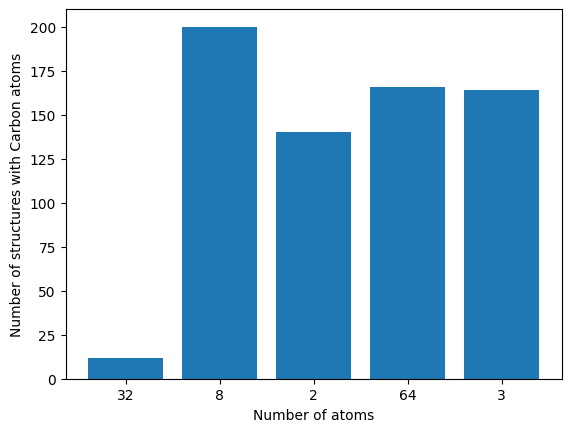

In [54]:
import matplotlib.pyplot as plt

n_atoms = df["n_atoms"].drop_duplicates()
counts = [df[df["n_atoms"] == i]["atomic_number"].apply(lambda x: 6 in x).sum() for i in n_atoms.to_list()]
x_labels = [str(i) for i in n_atoms.to_list()]
plt.bar(x_labels, counts)
plt.xlabel("Number of atoms")
plt.ylabel("Number of structures with Carbon atoms")